In [ ]:
# default_exp explorations

# explorations

In [1]:
%load_ext autoreload
%autoreload 2


In [14]:
# export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.decomposition import TruncatedSVD

from autoneuro.calculators import TestCalculator
from autoneuro.domains import *

In [8]:
all_neuro = pd.read_excel('data/neuro_data.xlsx',
                          na_values=['na', '-', 'nd']).groupby(['PatientID', 'Visit']).first().drop(['VisitDate'], axis=1)
all_neuro.replace({'Race': {2: 'AA',
                            1: 'white',
                            3: 'asian'},
                   'Sex': {1: 'male', 2: 'female'}},
                  inplace=True)

COLUMN_MAPPING = {'BVMTtrial1': 'trial1', 'BVMTtrial2': 'trial2', 'BVMTtrial3': 'trial3',
                  'BVMTdelay': 'delay',
                  'BVMThits': 'hits', 'BVMTfalsepos': 'false_pos',
                  'Stroop.word': 'stroop_word',
                  'Stroop.color': 'stroop_color',
                  'Stroop.colorword': 'stroop_color_word',
                  
                  'TrailA': 'trailA', 'TrailB': 'trailB',
                  
                  'DigitsForwardWAIS4': 'digits_forward',
                  'LDSFWAIS4': 'forward_lds',
                  'DigitsBackwardWAIS4': 'digits_backwards',
                  'LDSBWAIS4': 'backwards_lds',
                  'DigitsSequencingWAIS4': 'digits_sequencing',
                  'LDSSWAIS4': 'sequencing_lds',
                  
                  'LetterFluencyA.q1': 'letter_fluency_aq1',
                  'LetterFluencyA.q2': 'letter_fluency_aq2',
                  'LetterFluencyA.q3': 'letter_fluency_aq3',
                  'LetterFluencyA.q4': 'letter_fluency_aq4',
                  
                  'LetterFluencyF.q1': 'letter_fluency_fq1',
                  'LetterFluencyF.q2': 'letter_fluency_fq2',
                  'LetterFluencyF.q3': 'letter_fluency_fq3',
                  'LetterFluencyF.q4': 'letter_fluency_fq4',
                  
                  'LetterFluencyS.q1': 'letter_fluency_sq1',
                  'LetterFluencyS.q2': 'letter_fluency_sq2',
                  'LetterFluencyS.q3': 'letter_fluency_sq3',
                  'LetterFluencyS.q4': 'letter_fluency_sq4',
                  
                  'ROCF': 'rocf', 'ROCFtime': 'rocf_time',
                  'ClockCommand': 'clock_command', 'ClockCopy': 'clock_copy',


                  
                  
                  'Sex': 'gender', 'Race': 'race',
                  'Education': 'education', 'Age': 'age'}

all_neuro.head()


Age     Sex Race Race_specify  Education  EngFluency  \
PatientID Visit                                                         
1         1       59    male   AA         None         10         3.0   
          2       62    male   AA         None         11         NaN   
2         1       62  female   AA         None          9         3.0   
          2       67  female   AA         None         10         NaN   
4         1       65    male   AA         None          9         3.0   

                 SpanFluency  MMSE  DigitBackwardSENAS  \
PatientID Visit                                          
1         1              0.0  29.0                 6.0   
          2              NaN   NaN                 NaN   
2         1              0.0  19.0                 2.0   
          2              NaN   NaN                 NaN   
4         1              0.0  25.0                 4.0   

                 DigitBackwardSENAS.any  ...  Homeowner  Householdsize  \
PatientID Visit                          ...                             
1         1                        22.0  ...        0.0            1.0   
          2                         NaN  ...        NaN            NaN   
2         1                         NaN  ...        0.0            2.0   
          2                         NaN  ...        NaN            NaN   
4         1                        24.0  ...        0.0            1.0   

                 Earnings.Indiv  Income.Indiv  Earnings.House  Income.House  \
PatientID Visit                                                               
1         1                 0.0         720.0             0.0         720.0   
          2                 NaN           NaN             NaN           NaN   
2         1                 0.0         730.0             0.0        1570.0   
          2                 NaN           NaN             NaN           NaN   
4         1                 0.0         720.0             0.0         720.0   

                 Income.House.Weighted1  Income.House.Weighted2  Effort  \
PatientID Visit                                                           
1         1                       720.0                   720.0     5.0   
          2                         NaN                     NaN     NaN   
2         1                       785.0                   785.0     4.0   
          2                         NaN                     NaN     NaN   
4         1                       720.0                   720.0     5.0   

                 Unnamed: 165  
PatientID Visit                
1         1               NaN  
          2               NaN  
2         1               NaN  
          2               NaN  
4         1               NaN  

[5 rows x 163 columns]

In [ ]:
mem_domain = MemoryDomain.from_defaults()
mem_domain.load_data(all_neuro, mapping=COLUMN_MAPPING)

ex_fun_domain = ExecutiveFunctionDomain.from_defaults()
ex_fun_domain.load_data(all_neuro, mapping=COLUMN_MAPPING)

attn_domain = AttentionDomain.from_defaults()
attn_domain.load_data(all_neuro, mapping=COLUMN_MAPPING)

lang_domain = LanguageDomain.from_defaults()
lang_domain.load_data(all_neuro, mapping=COLUMN_MAPPING)

vs_domain = VisuoSpatialDomain.from_defaults()
vs_domain.load_data(all_neuro, mapping=COLUMN_MAPPING)

all_normed = pd.DataFrame({'memory': mem_domain.data['aggregated_score'],
                           'language': lang_domain.data['aggregated_score'],
                           'visuaspatial': vs_domain.data['aggregated_score'],
                           'attn_workmem': attn_domain.data['aggregated_score'],
                           'executive_function': ex_fun_domain.data['aggregated_score']})

domains = [('Memory', mem_domain), ('Language', lang_domain), ('Visuospatial', vs_domain), ('Attention & Working Memory', attn_domain), ('Executive Function', ex_fun_domain)]

# Individual Domains

Each domain is a collection of individual tests. Each of which is normalized to remove the effects of (at least) age.
The collection of these individual tests is aggregated into a domain score using a weighted sum proportional to the variance.

## Executive Function

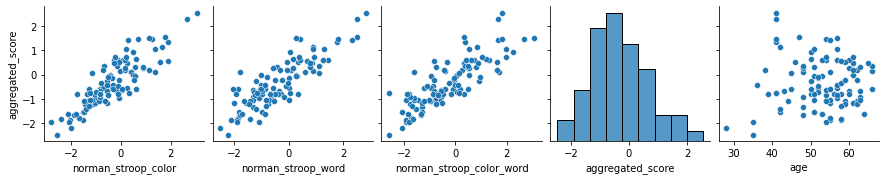

In [39]:
ex_fun_domain.build_pairplot(pairplot_kwargs={"y_vars": ['aggregated_score'], 
                                              'x_vars': ['norman_stroop_color',
                                                        'norman_stroop_word','norman_stroop_color_word', 'aggregated_score',
                                                         'age']})

The `aggregated_score` is the weighted sum of the sub-tests and represents the "domain score".
We can also see that our age normalization worked because our resulting scores are uncorrelated with age.
The values are in z-scale, so 0 is "average", -0.5 is mild impairment, -1 is moderate, -1.5 is severe.

## Memory

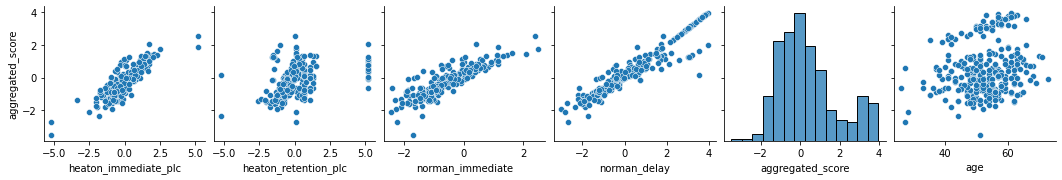

In [40]:
mem_domain.build_pairplot(pairplot_kwargs={"y_vars": ['aggregated_score'], 
                                              'x_vars': mem_domain.final_fields + ['aggregated_score',
                                                                                   'age']})

## Language (incomplete & self-normed)

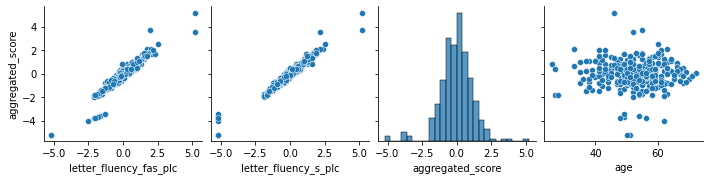

In [41]:
lang_domain.build_pairplot(pairplot_kwargs={"y_vars": ['aggregated_score'], 
                                              'x_vars': lang_domain.final_fields + ['aggregated_score',
                                                                                   'age']})

## Attention & Working Memory (self-normed)

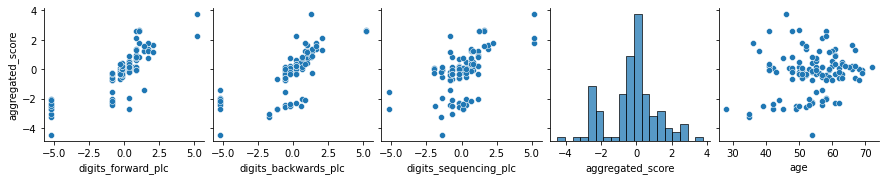

In [42]:
attn_domain.build_pairplot(pairplot_kwargs={"y_vars": ['aggregated_score'], 
                                              'x_vars': attn_domain.final_fields + ['aggregated_score',
                                                                                   'age']})

## Visuospatial (self-normed)

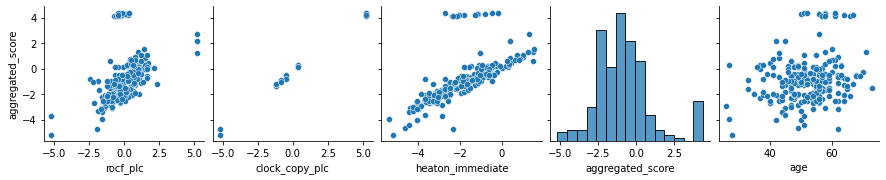

In [43]:
vs_domain.build_pairplot(pairplot_kwargs={"y_vars": ['aggregated_score'], 
                                              'x_vars': vs_domain.final_fields + ['aggregated_score',
                                                                                   'age']})

## Tests together

This looks at how much each individual test contributes to the domain score.

Text(0.5, 1.0, 'Combined')

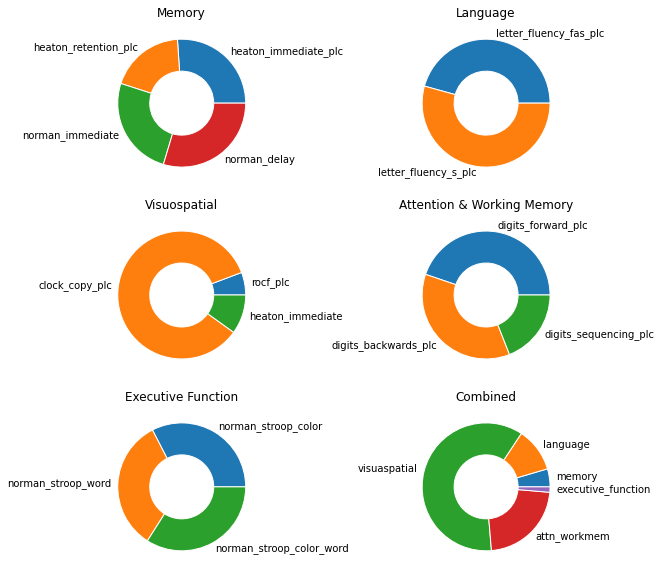

In [44]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))
for ax, (name, dmn) in zip(axs.flatten(), domains):
    
    dmn.build_piechart(ax=ax)
    ax.set_title(name)
    
svd = TruncatedSVD().fit(all_normed.dropna())

weights = np.abs(svd.components_[0, :]) # Deal with sign
weights = weights / np.sum(weights) # Deal with scale
weights = pd.Series(weights, index = all_normed.columns)

ax = axs.flatten()[-1]
ax.pie(weights,
       labels = weights.index,
       wedgeprops=dict(width=0.5, edgecolor='w'))
ax.set_title('Combined')

# Across Domains

Text(0.5, 0, '% Samples')

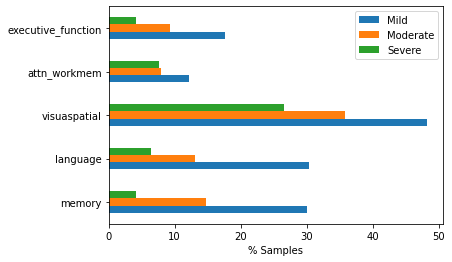

In [45]:
found = pd.DataFrame({#'Any': (all_normed<0).mean(),
                      'Mild': (all_normed<-0.5).mean(),
                      'Moderate': (all_normed<-1).mean(),
                      'Severe': (all_normed<-1.5).mean()})

fig, ax = plt.subplots(1,1)
(100*found).plot(kind = 'barh', ax=ax)
ax.set_xlabel('% Samples')

In [50]:
len(all_normed.index)

313

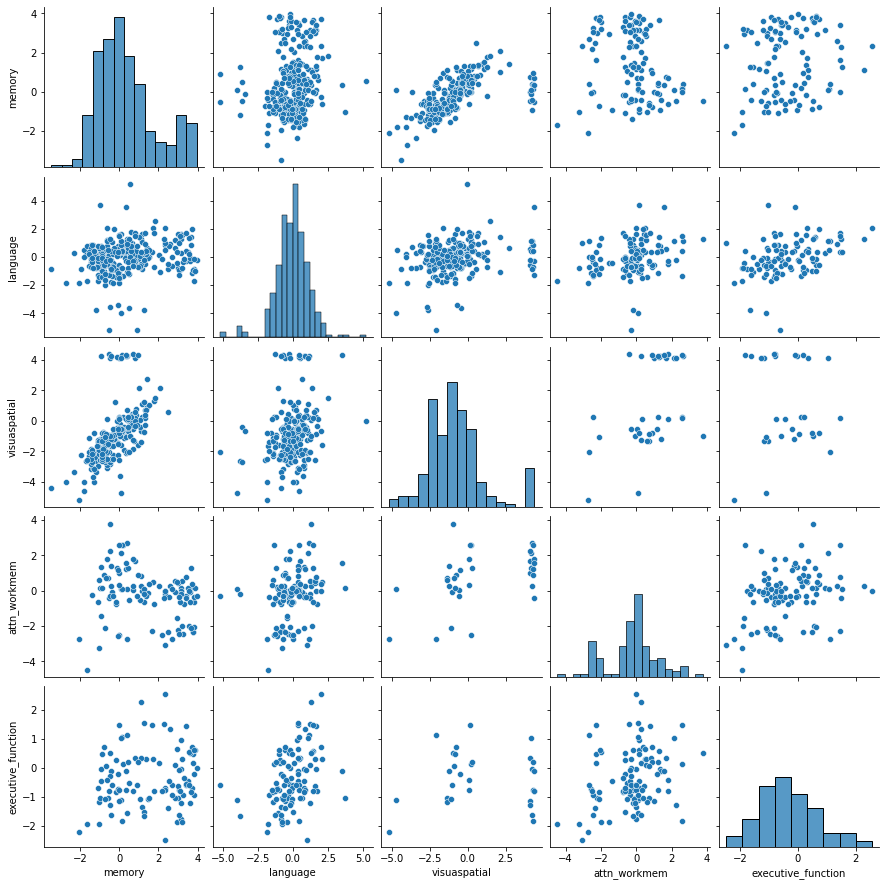

In [46]:
sbn.pairplot(all_normed)

<AxesSubplot:>

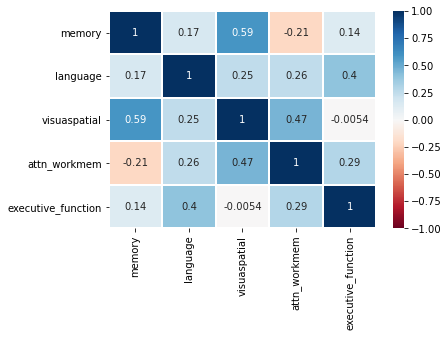

In [12]:
sbn.heatmap(all_normed.corr(), 
            vmin = -1, vmax=1, annot=True, cmap = 'RdBu', lw=1)

<AxesSubplot:ylabel='Frequency'>

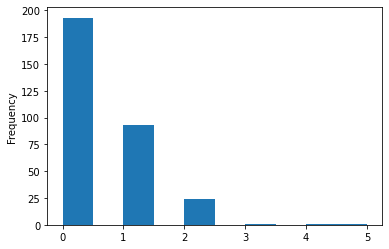

In [54]:
(all_normed<-1.5).sum(axis=1).plot(kind = 'hist')